## Overview
The kernel goes through

1. the preprocessing steps to load the data
2. a quick visualization of the color-space
3. training a simple CNN
4. applying the model to the test data
5. creating the RLE test data

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Path / Directory Settings
path = './Input_Data/'
stage_label = 'stage1'

print(path)

./Input_Data/


## Read in the labels
Load the RLE-encoded output for the training set

In [9]:
train_labels = pd.read_csv(os.path.join(path,'{}_train_labels.csv'.format(stage_label)))
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
train_labels.sample(3)

,ImageId,EncodedPixels
10266,547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3c...,"[283645, 10, 284163, 17, 284682, 19, 285202, 2..."
11250,5b12df18e4ae4df5af06052584cf0e6bef58ee2a220653...,"[13230, 7, 13486, 9, 13742, 10, 13998, 11, 142..."
20320,a9d884ba0929dac87c2052ce5b15034163685317d7cff4...,"[2559, 2, 2814, 3, 3069, 4, 3325, 4, 3581, 4, ..."


## Load in all Images
Here we load in the images and process the paths so we have the appropriate information for each image

In [34]:
all_images = glob(os.path.join(path, 'stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})

img_id = lambda in_path: in_path.split('\\')[-3]
img_type = lambda in_path: in_path.split('\\')[-2]
img_group = lambda in_path: in_path.split('\\')[-4].split('_')[1]
img_stage = lambda in_path: in_path.split('\\')[-4].split('_')[0]

img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)

img_df.sample(5)

./Input_Data\stage1_test\0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac\images\0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac.png


,path,ImageId,ImageType,TrainingSplit,Stage
29794,./Input_Data\stage1_train\fa751ff3a6332c95cb5c...,fa751ff3a6332c95cb5cb1d28563553914295e9e7d35c4...,masks,train,stage1
8878,./Input_Data\stage1_train\4a424e0cb845cf6fd4d9...,4a424e0cb845cf6fd4d9fe62875552c7b89a4e0276cf16...,masks,train,stage1
21054,./Input_Data\stage1_train\aaa52100fafaa50877e7...,aaa52100fafaa50877e777229cdf6cde7c422f145ff671...,masks,train,stage1
12908,./Input_Data\stage1_train\648636ee314d7bdba3ab...,648636ee314d7bdba3ab2fc0fe49a863de35c3e2caf619...,masks,train,stage1
5365,./Input_Data\stage1_train\29780b28e6a75fac7b96...,29780b28e6a75fac7b96f164a1580666513199794f1b19...,masks,train,stage1


## Create Training Data
Make training data and load all images into dataframe.

We take the simplification here of grouping all the regions together (rather than keeping them distinct).

In [56]:
%%time

train_df = img_df.query('TrainingSplit == "train"')

train_rows = []
group_cols = ['Stage', 'ImageId']

for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
    
train_img_df = pd.DataFrame(train_rows)

IMG_CHANNELS = 3

def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0) / 255.0

train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:, :, :IMG_CHANNELS])
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))

train_img_df.sample(2)

print(train_img_df['images'][1].shape)

(256, 256, 3)
Wall time: 5min 38s


## Show a few images
Here we show a few images of the cells where we see there is a mixture of brightfield and fluorescence

This will probably make a single segmentation algorithm difficult

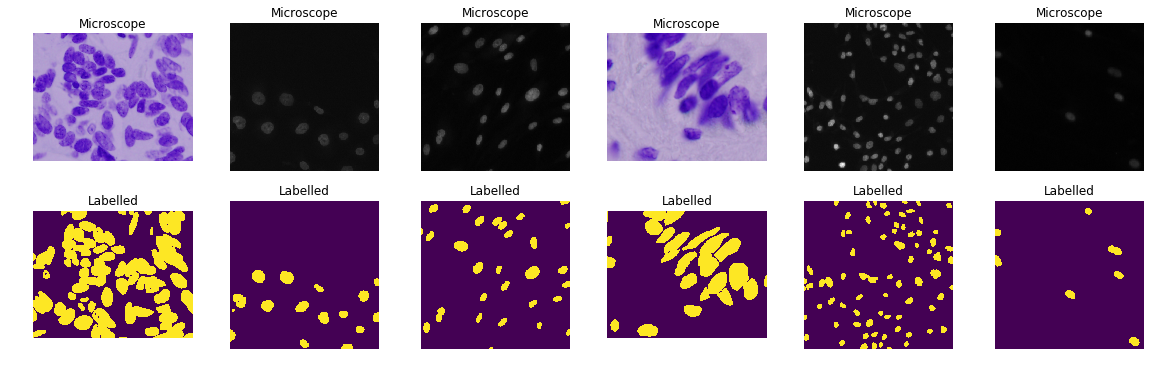

In [58]:
n_img = 6
fig, m_axs = plt.subplots(2, n_img, figsize= (20, 6))

for(_, c_row), (c_im, c_lab) in zip(train_img_df.sample(n_img).iterrows(), m_axs.T):
    
    c_im.imshow(c_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(c_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Labelled')  
    

## Look at the intensity distribution
Here we look at the intensity distribution and see a few groups forming.

They should probably be handled separately.

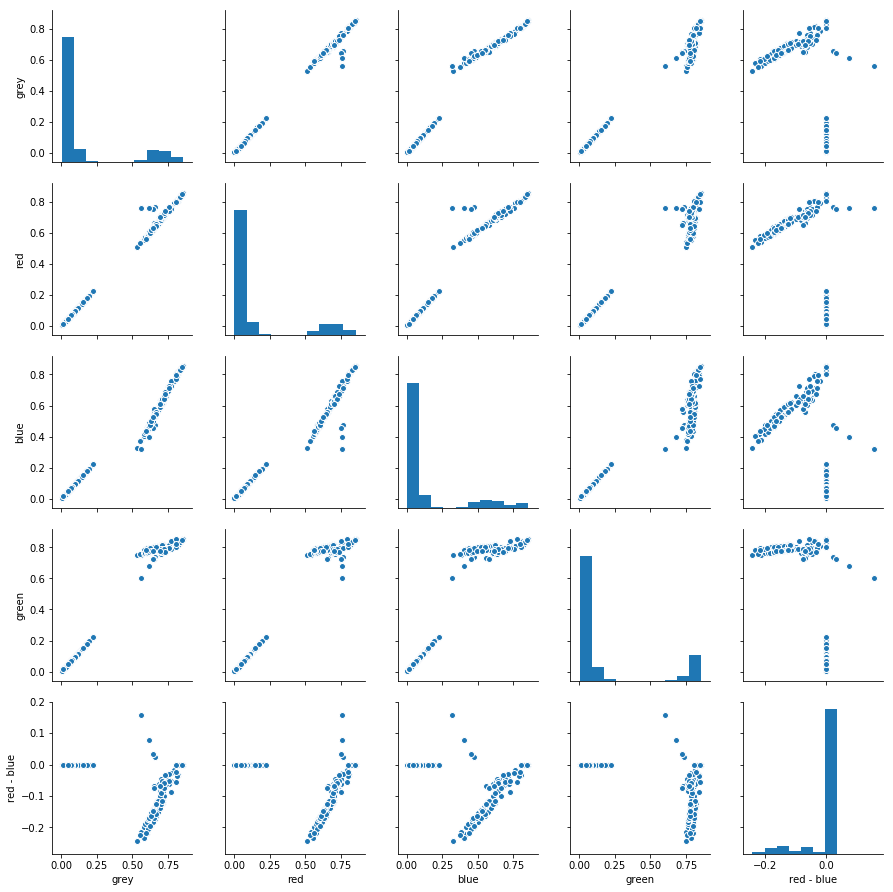

In [61]:
train_img_df['red'] = train_img_df['images'].map(lambda x: np.mean(x[:, :, 0]))
train_img_df['blue'] = train_img_df['images'].map(lambda x: np.mean(x[:, :, 1]))
train_img_df['green'] = train_img_df['images'].map(lambda x: np.mean(x[:, :, 2]))
train_img_df['grey'] = train_img_df['images'].map(lambda x: np.mean(x))
train_img_df['red - blue'] = train_img_df['images'].map(lambda x: np.mean(x[:, :, 0] - x[:, :, 2]))

sns.pairplot(train_img_df[['grey', 'red', 'blue', 'green', 'red - blue']])


## Check Dimensions
Here we show the dimensions of the data to see the variety in the input images

In [62]:
train_img_df['images'].map(lambda x: x.shape).value_counts()

(256, 256, 3)      334
(256, 320, 3)      112
(520, 696, 3)       92
(360, 360, 3)       91
(1024, 1024, 3)     16
(512, 640, 3)       13
(603, 1272, 3)       6
(260, 347, 3)        5
(1040, 1388, 3)      1
Name: images, dtype: int64

## Making a simple CNN
Make a very simple CNN to get a quick idea of how well it works.

For this we use batch normalisation to normalise the inputs. We cheat a bit with padding to keep problems simple.

In [63]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, UpSampling2D, Lambda

In [73]:
simple_cnn = Sequential()

simple_cnn.add(BatchNormalization(input_shape= (None, None, IMG_CHANNELS), name= 'NormalizeInput'))

simple_cnn.add(Conv2D(8, kernel_size= (3, 3), padding= 'same'))
simple_cnn.add(Conv2D(8, kernel_size= (3, 3), padding= 'same'))
# Use dilations to get slightly larger field of view
simple_cnn.add(Conv2D(16, kernel_size= (3, 3), dilation_rate= 2, padding= 'same'))
simple_cnn.add(Conv2D(16, kernel_size= (3, 3), dilation_rate= 2, padding= 'same'))
simple_cnn.add(Conv2D(32, kernel_size= (3, 3), dilation_rate= 3, padding= 'same'))

# The final processing
simple_cnn.add(Conv2D(16, kernel_size= (1, 1), padding= 'same'))
simple_cnn.add(Conv2D(1, kernel_size= (1, 1), padding= 'same', activation= 'sigmoid'))

simple_cnn.summary()

# from keras.utils import plot_model
# import pydot
# import graphviz
# plot_model(simple_cnn, to_file= 'model layout')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, None, None, 3)     12        
_________________________________________________________________
conv2d_64 (Conv2D)           (None, None, None, 8)     224       
_________________________________________________________________
conv2d_65 (Conv2D)           (None, None, None, 8)     584       
_________________________________________________________________
conv2d_66 (Conv2D)           (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_67 (Conv2D)           (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_68 (Conv2D)           (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_69 (Conv2D)           (None, None, None, 16)    528       
__________

In [98]:
# from keras.utils import plot_model
# import pydot
# import graphviz
# plot_model(simple_cnn, to_file= 'model layout')

## Loss
Since we are being evaluated with intersection over union, we can use the inverse of the DICE score as a loss function to optimise

In [75]:
from keras import backend as K
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

simple_cnn.compile(optimizer= 'adam', loss= dice_coef_loss, metrics= [dice_coef, 'acc', 'mse'])    

## Simple Training
Here we run a simple training with each image as a single batch (not a great idea), but it keeps the code simple

In [76]:
def simple_gen():
    while True:
        for _, c_row in train_img_df.iterrows():
            yield np.expand_dims(c_row['images'], 0), np.expand_dims(np.expand_dims(c_row['masks'], -1), 0)
            
simple_cnn.fit_generator(simple_gen(), steps_per_epoch= train_img_df.shape[0], epochs= 3)

Epoch 1/3
670/670 [==============================] - 994s 1s/step - loss: -0.7409 - dice_coef: 0.7409 - acc: 0.9057 - mean_squared_error: 0.0892
Epoch 2/3
670/670 [==============================] - 976s 1s/step - loss: -0.7995 - dice_coef: 0.7995 - acc: 0.9297 - mean_squared_error: 0.0682
Epoch 3/3
670/670 [==============================] - 960s 1s/step - loss: -0.8064 - dice_coef: 0.8064 - acc: 0.9314 - mean_squared_error: 0.0672


## Apply Model to Test Data

In [115]:
%%time

test_df = img_df.query('TrainingSplit == "test"')

test_rows = []
nLoops = 0

group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]
    nLoops += 1
test_img_df = pd.DataFrame(test_rows)

test_img_df['images'] = test_img_df['images'].map(read_and_stack).map(lambda x: x[:, :, :IMG_CHANNELS])
print(test_img_df.shape[0], 'images to process')
test_img_df.sample(1)

print(test_df)

65 images to process
                                                 path  \
0   ./Input_Data\stage1_test\0114f484a16c152baa2d8...   
1   ./Input_Data\stage1_test\0999dab07b11bc85fb846...   
2   ./Input_Data\stage1_test\0a849e0eb15faa8a6d732...   
3   ./Input_Data\stage1_test\0e132f71c8b4875c3c2dd...   
4   ./Input_Data\stage1_test\0ed3555a4bd48046d3b63...   
5   ./Input_Data\stage1_test\0f1f896d9ae5a04752d32...   
6   ./Input_Data\stage1_test\1747f62148a919c8feb6d...   
7   ./Input_Data\stage1_test\17b9bf4356db24967c467...   
8   ./Input_Data\stage1_test\1879f4f4f05e2bada0ffe...   
9   ./Input_Data\stage1_test\191b2b2205f2f5cc9da04...   
10  ./Input_Data\stage1_test\1962d0c5faf3e85cda80e...   
11  ./Input_Data\stage1_test\1cdbfee1951356e7b0a21...   
12  ./Input_Data\stage1_test\1d9eacb3161f1e2b45550...   
13  ./Input_Data\stage1_test\1ef68e93964c2d9230100...   
14  ./Input_Data\stage1_test\259b35151d4a7a5ffdd7a...   
15  ./Input_Data\stage1_test\295682d9eb5acb5c1976a...   
16  ./Inpu

In [116]:
%%time

test_img_df['masks'] = test_img_df['images'].map(lambda x: simple_cnn.predict(np.expand_dims(x, 0))[0, :, :, 0])

Wall time: 1min 5s


## Show a few predictions

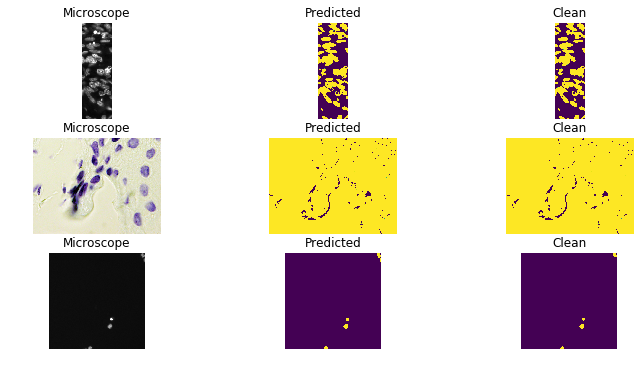

In [117]:
n_img = 3

from skimage.morphology import closing, opening, disk
def clean_img(x):
    return opening(closing(x, disk(1)), disk(3))

fig, m_axs = plt.subplots(3, n_img, figsize = (12, 6))
for (_, d_row), (c_im, c_lab, c_clean) in zip(test_img_df.sample(n_img).iterrows(), m_axs):
    
    c_im.imshow(d_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(d_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Predicted')
    
    c_clean.imshow(clean_img(d_row['masks']))
    c_clean.axis('off')
    c_clean.set_title('Clean')
    
    

## Check RLE

In [118]:
from skimage.morphology import label
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    
    Returns run length as a list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)
        

## Calculate RLEs for a Train Image

In [120]:
_, train_rle_row = next(train_img_df.tail(5).iterrows())
train_row_rles = list(prob_to_rles(train_rle_row['masks']))

## Take the RLEs from the CSV
Take RLE from training labels csv file, to check how well the true labels match up with our RLE function

In [121]:
tl_rles = train_labels.query('ImageId == "{ImageId}"'.format(**train_rle_row))['EncodedPixels']

## Check

Since we made some simplifications, don't expect everything to match perfectly, but pretty close

In [122]:
match, mismatch = 0, 0
for img_rle, train_rle in zip(sorted(train_row_rles, key = lambda x: x[0]), sorted(tl_rles, key = lambda x: x[0])):
    for i_x, i_y in zip(img_rle, train_rle):
        if i_x == i_y:
            match += 1
        else:
            mismatch += 1
            
print('Matches: %d, Mismatches: %d, Accuracy: %2.1f%%' % (match, mismatch, 100.0*match/(match + mismatch)))


Matches: 360, Mismatches: 0, Accuracy: 100.0%


## Calculate RLEs for all the Masks
Here we generate the RLE for all the masks and output the results to a table.

We use a few morphological operations to clean up the images before submission since they can be very messy (remove single pixels, connect nearby regions etc.)

In [123]:
test_img_df['rles'] = test_img_df['masks'].map(clean_img).map(lambda x: list(prob_to_rles(x)))

In [124]:
out_pred_list = []
for _, c_row in test_img_df.iterrows():
    for c_rle in c_row['rles']:
        out_pred_list += [dict(ImageId = c_row['ImageId'], EncodedPixels = ' '.join(np.array(c_rle).astype(str)))]
out_pred_df = pd.DataFrame(out_pred_list)
print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
out_pred_df.sample(3)

1513 regions found for 65 images


,EncodedPixels,ImageId
803,3374 3 3892 7 4411 8 4930 10 5449 11 5968 13 6...,78a981bd27ba0c65a9169548665a17bda9f49050d0d389...
1253,62179 5 62188 3 62696 17 63214 20 63734 20 642...,d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633f...
1468,17960 4 18214 8 18469 9 18724 11 18980 11 1923...,fe9adb627a6f45747c5a8223b671774791ededf9364f65...


In [125]:
out_pred_df[['ImageId', 'EncodedPixels']].to_csv('predictions.csv', index = False)